In [1]:
# Modify sys paths for importing development module
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath(".")))

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from worker.pdetection.bodypose import BodyPoseDetector

%load_ext autoreload
%autoreload 2

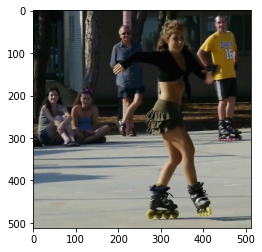

In [21]:
img = cv2.imread("ski.jpg", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))

plt.imshow(img)

In [15]:
detecotor = BodyPoseDetector(device="cuda")

In [34]:
%%time

peoples = detecotor([img])

CPU times: user 570 ms, sys: 86.5 ms, total: 656 ms
Wall time: 421 ms


In [17]:
len(peoples[0])

5

In [30]:
import math

def draw_bodypose(frame, keypoints):
    stickwidth = 4
    limbs = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], \
             [2, 9], [9, 10], [10, 11], [2, 12], [12, 13], [13, 14], \
             [2, 1], [1, 15], [15, 17], [1, 16], [16, 18]]
    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], \
              [0, 255, 0], [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], \
              [0, 0, 255], [85, 0, 255], [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
    
    # Draw keypoints
    for i, keypoint in enumerate(keypoints):
        if keypoint[-1] == 0:
            continue
        x = int(keypoint[0])
        y = int(keypoint[1])
        cv2.circle(frame, (x, y), 4, colors[i], thickness=-1)

    # Draw limbs
    cur_canvas = frame.copy()
    for i, (limb, color) in enumerate(zip(limbs, colors)):
        keypointA = np.array(keypoints[limb[0]-1])
        keypointB = np.array(keypoints[limb[1]-1])
        if keypointA[-1] == 0 or keypointB[-1] == 0:
            continue
        keypointA = keypointA[:2]
        keypointB = keypointB[:2]
        mean = (keypointA + keypointB) / 2
        mean = mean.astype(np.int)
        length = np.sqrt(np.sum((keypointA-keypointB)**2))
        
        orientation = keypointB - keypointA
        angle = math.degrees(math.atan2(orientation[1], orientation[0]))
        polygon = cv2.ellipse2Poly(tuple(mean), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, color)

    frame[:, :, :] = frame*0.4 + cur_canvas*0.6

In [31]:
from app.utils.visualize import draw_bbox

for person in peoples[0]:
    draw_bodypose(img, person['keypoints'])
    draw_bbox(img, person['bbox'])

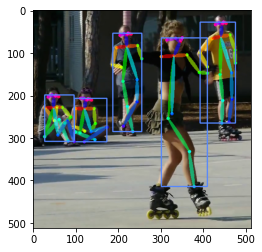

In [32]:
plt.imshow(img)